In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import time
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm


In [2]:
df = pd.read_csv("datasets/Cancer_Data.csv")

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())

Dataset shape: (569, 33)

First few rows:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_wors

In [3]:
# Data preprocessing
def preprocess_data(df):
    # Create a copy to avoid modifying original data
    data = df.copy()

    # Encode diagnosis (M=1, B=0)
    le = LabelEncoder()
    data['diagnosis_encoded'] = le.fit_transform(data['diagnosis'])

    # Separate features and target
    X = data.drop(['id', 'diagnosis', 'diagnosis_encoded'], axis=1)
    y = data['diagnosis_encoded']

    return X, y, data

X, y, processed_data = preprocess_data(df)
print(f"\nFeatures shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")


Features shape: (569, 31)
Target distribution:
diagnosis_encoded
0    357
1    212
Name: count, dtype: int64


## Part 1: Apriori and Rule Mining -- Feature Engineering and Outlier Detection

## Model Performance

In [4]:
# Apriori-based feature engineering
def apriori_feature_engineering(X, y, min_support=0.35, min_confidence=0.7):
    """
    Use Apriori algorithm to generate association rules and create new features
    """
    # Create binary features for Apriori (binarize continuous features)
    X_binarized = X.copy()

    # Binarize features using median (can use other methods)
    for column in X_binarized.columns:
        median_val = X_binarized[column].median()
        X_binarized[column] = (X_binarized[column] > median_val).astype(int)

    # Add target to the binarized dataset for association rule mining
    X_binarized_with_target = X_binarized.copy()
    X_binarized_with_target['diagnosis'] = y.values

    # Generate frequent itemsets using Apriori
    start_time = time.time()
    frequent_itemsets = apriori(X_binarized_with_target,
                               min_support=min_support,
                               use_colnames=True)
    apriori_growth_time = time.time() - start_time

    print(f"Apriori generated {len(frequent_itemsets)} frequent itemsets in {apriori_growth_time:.4f} seconds")


    # Generate association rules
    if len(frequent_itemsets) > 0:
        start_time = time.time()
        rules = association_rules(frequent_itemsets,
                                 metric="confidence",
                                 min_threshold=min_confidence)
        rule_generation_time = time.time() - start_time

        print(f"Generated {len(rules)} association rules in {rule_generation_time:.4f} seconds")


        # Time just the feature creation
        start_feature_time = time.time()

        # Create new features based on association rules
        X_enhanced = X.copy()

        # Select top rules by lift for feature engineering
        top_rules = rules.nlargest(min(20000, len(rules)), 'lift')

        # Add rule-based features with progress bar
        for idx, rule in tqdm(top_rules.iterrows(), total=len(top_rules), desc="Creating features"):
            if len(rule['antecedents']) > 0:
                # Create feature based on rule antecedent conditions
                rule_name = f"rule_{idx}"
                antecedent_conditions = []

                for antecedent in rule['antecedents']:
                    if antecedent != 'diagnosis':
                        median_val = X[antecedent].median()
                        antecedent_conditions.append(X[antecedent] > median_val)

                if antecedent_conditions:
                    # Combine conditions (AND operation)
                    combined_condition = antecedent_conditions[0]
                    for condition in antecedent_conditions[1:]:
                        combined_condition = combined_condition & condition

                    X_enhanced[rule_name] = combined_condition.astype(int)


        feature_creation_time = time.time() - start_feature_time
        # print(f"Feature creation took: {feature_creation_time:.4f} seconds")


        return X_enhanced, rules, apriori_growth_time + rule_generation_time
    else:
        print("No frequent itemsets found. Returning original features.")
        return X, pd.DataFrame()

In [5]:
# Function for outlier detection using association rules
def detect_outliers_apriori(X, y, rules, threshold=0.1):
    """
    Detect outliers based on association rule violations
    """
    if rules.empty:
        return np.array([])

    outlier_scores = np.zeros(len(X))

    # # Select top rules by lift for feature engineering
    # top_rules = rules.nlargest(min(10, len(rules)), 'lift')

    # for idx, rule in tqdm(top_rules.iterrows(), total=len(top_rules), desc="Finding Outliers"):
    for idx, rule in tqdm(rules.iterrows(), total=len(rules), desc="Finding Outliers"):
        if len(rule['antecedents']) > 0 and len(rule['consequents']) > 0:
            # Calculate how many samples violate this rule
            violation_count = 0
            for i in range(len(X)):
                antecedent_true = True
                consequent_true = True

                # Check antecedents
                for antecedent in rule['antecedents']:
                    if antecedent != 'diagnosis':
                        median_val = X[antecedent].median()
                        if not (X[antecedent].iloc[i] > median_val):
                            antecedent_true = False
                            break

                # Check consequents
                for consequent in rule['consequents']:
                    if consequent != 'diagnosis':
                        median_val = X[consequent].median()
                        if not (X[consequent].iloc[i] > median_val):
                            consequent_true = False
                            break

                # If antecedents are true but consequents are false, it's a violation
                if antecedent_true and not consequent_true:
                    violation_count += 1
                    outlier_scores[i] += 1

    # Normalize outlier scores
    if outlier_scores.max() > 0:
        outlier_scores = outlier_scores / outlier_scores.max()

    # Identify outliers
    outliers = outlier_scores > threshold
    print(f"Detected {outliers.sum()} potential outliers")

    return outliers



In [6]:
# Evaluate Random Forest performance
def evaluate_random_forest(X, y, outlier_mask=None):
    """
    Evaluate Random Forest classifier with optional outlier removal
    """
    if outlier_mask is not None:
        # Remove outliers
        X_clean = X[~outlier_mask]
        y_clean = y[~outlier_mask]
        print(f"After outlier removal: {len(X_clean)} samples")
    else:
        X_clean = X
        y_clean = y

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_clean, test_size=0.3, random_state=42, stratify=y_clean
    )

    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Cross-validation
    cv_scores = cross_val_score(rf, X_scaled, y_clean, cv=5)

    return accuracy, cv_scores.mean(), rf


In [7]:
# Main execution for Open Task (Part 1)
print("=" * 60)
print("Open Task -- PART 1 : APRIORI ASSOCIATION RULE MINING FOR FEATURE ENGINEERING")
print("=" * 60)

# (A) Random Forest without Apriori
print("\n(A) RANDOM FOREST WITHOUT APRIORI FEATURE ENGINEERING")
start_time = time.time()

accuracy_a, cv_score_a, rf_a = evaluate_random_forest(X, y)
print(f"Accuracy: {accuracy_a:.4f}")
print(f"Cross-validation Score: {cv_score_a:.4f}")
print(f"Time taken: {time.time() - start_time:.2f} seconds")

# (B) Random Forest with Apriori feature engineering
print("\n(B) RANDOM FOREST WITH APRIORI FEATURE ENGINEERING")
start_time = time.time()

# Generate enhanced features using Apriori
X_enhanced, rules, apriori_time = apriori_feature_engineering(X, y, min_support=0.35, min_confidence=0.7)
print(f"Final: {len(rules)} rules, {X_enhanced.shape[1]} features")

# Detect outliers using association rules
outlier_mask = detect_outliers_apriori(X, y, rules, threshold=0.2)

# Evaluate with enhanced features and outlier removal
accuracy_b, cv_score_b, rf_b = evaluate_random_forest(X_enhanced, y, outlier_mask)
print(f"Accuracy: {accuracy_b:.4f}")
print(f"Cross-validation Score: {cv_score_b:.4f}")
print(f"Execution Time / Total Time taken: {time.time() - start_time:.2f} seconds")

# Comparison
print("\n" + "=" * 60)
print("PERFORMANCE COMPARISON")
print("=" * 60)
print(f"(A) Without Apriori - Accuracy: {accuracy_a:.4f}, CV Score: {cv_score_a:.4f}")
print(f"(B) With Apriori (+ Outlier Removed) - Accuracy: {accuracy_b:.4f}, CV Score: {cv_score_b:.4f}")

improvement = ((accuracy_b - accuracy_a) / accuracy_a) * 100
cv_improvement = ((cv_score_b - cv_score_a) / cv_score_a) * 100

print(f"\nAccuracy Improvement: {improvement:+.2f}%")
print(f"CV Score Improvement: {cv_improvement:+.2f}%")

# Feature importance comparison
print("\nFEATURE IMPORTANCE ANALYSIS")
feature_importance_a = pd.DataFrame({
    'feature': X.columns,
    'importance_A': rf_a.feature_importances_
}).sort_values('importance_A', ascending=False)

print("Top 10 features without Apriori:")
print(feature_importance_a.head(10))

if len(X_enhanced.columns) > len(X.columns):
    # Get original feature importances from model B
    original_feature_names = X.columns
    enhanced_feature_importances = rf_b.feature_importances_

    # Separate original and new features
    original_importances = []
    new_rule_features = []

    for i, feature in enumerate(X_enhanced.columns):
        if feature in original_feature_names:
            original_importances.append(enhanced_feature_importances[i])
        else:
            new_rule_features.append((feature, enhanced_feature_importances[i]))

    feature_importance_b = pd.DataFrame({
        'feature': original_feature_names,
        'importance_B': original_importances
    }).sort_values('importance_B', ascending=False)

    print("\nTop 10 original features with Apriori:")
    print(feature_importance_b.head(10))

    if new_rule_features:
        print("\nRule-based features and their importance:")
        for feature, importance in sorted(new_rule_features, key=lambda x: x[1], reverse=True)[:5]:
            print(f"  {feature}: {importance:.4f}")



Open Task -- PART 1 : APRIORI ASSOCIATION RULE MINING FOR FEATURE ENGINEERING

(A) RANDOM FOREST WITHOUT APRIORI FEATURE ENGINEERING
Accuracy: 0.9649
Cross-validation Score: 0.9578
Time taken: 1.03 seconds

(B) RANDOM FOREST WITH APRIORI FEATURE ENGINEERING
Apriori generated 988 frequent itemsets in 0.0419 seconds
Generated 26042 association rules in 0.1567 seconds


Creating features: 100%|██████████| 20000/20000 [01:14<00:00, 267.23it/s]


Final: 26042 rules, 20028 features


Finding Outliers: 100%|██████████| 26042/26042 [20:23<00:00, 21.29it/s]  


Detected 124 potential outliers
After outlier removal: 445 samples
Accuracy: 0.9851
Cross-validation Score: 0.9730
Execution Time / Total Time taken: 1302.57 seconds

PERFORMANCE COMPARISON
(A) Without Apriori - Accuracy: 0.9649, CV Score: 0.9578
(B) With Apriori (+ Outlier Removed) - Accuracy: 0.9851, CV Score: 0.9730

Accuracy Improvement: +2.09%
CV Score Improvement: +1.59%

FEATURE IMPORTANCE ANALYSIS
Top 10 features without Apriori:
                 feature  importance_A
22       perimeter_worst      0.155815
7    concave points_mean      0.115585
27  concave points_worst      0.113682
23            area_worst      0.096887
20          radius_worst      0.094468
0            radius_mean      0.068950
3              area_mean      0.051554
6         concavity_mean      0.043068
13               area_se      0.039128
2         perimeter_mean      0.022765

Top 10 original features with Apriori:
                   feature  importance_B
3                area_mean      0.010601
22     

## Part 2: Gaining Inspiration and Finding New Algorithm

In [8]:
def fp_growth_feature_engineering(X, y, min_support=0.35, min_confidence=0.7):
    """
    Use FP-Growth algorithm for feature engineering
    """
    # Create binary features
    X_binarized = X.copy()
    for column in X_binarized.columns:
        median_val = X_binarized[column].median()
        X_binarized[column] = (X_binarized[column] > median_val).astype(int)

    # Add target
    X_binarized_with_target = X_binarized.copy()
    X_binarized_with_target['diagnosis'] = y.values

    # Use FP-Growth instead of Apriori
    start_time = time.time()
    frequent_itemsets_fp = fpgrowth(X_binarized_with_target,
                                   min_support=min_support,
                                   use_colnames=True)
    fp_growth_time = time.time() - start_time

    print(f"FP-Growth generated {len(frequent_itemsets_fp)} frequent itemsets in {fp_growth_time:.4f} seconds")

    # Generate association rules
    if len(frequent_itemsets_fp) > 0:
        start_time = time.time()
        rules_fp = association_rules(frequent_itemsets_fp,
                                    metric="confidence",
                                    min_threshold=min_confidence)
        rule_generation_time = time.time() - start_time

        print(f"Generated {len(rules_fp)} association rules in {rule_generation_time:.4f} seconds")


        # Time just the feature creation
        start_feature_time = time.time()

        # Create enhanced features
        X_enhanced_fp = X.copy()

        # Select top rules by lift for feature engineering
        top_rules = rules_fp.nlargest(min(20000, len(rules_fp)), 'lift')

        for idx, rule in tqdm(top_rules.iterrows(), total=len(top_rules), desc="Creating features"):
            if len(rule['antecedents']) > 0:
                rule_name = f"fp_rule_{idx}"
                antecedent_conditions = []

                for antecedent in rule['antecedents']:
                    if antecedent != 'diagnosis':
                        median_val = X[antecedent].median()
                        antecedent_conditions.append(X[antecedent] > median_val)

                if antecedent_conditions:
                    combined_condition = antecedent_conditions[0]
                    for condition in antecedent_conditions[1:]:
                        combined_condition = combined_condition & condition

                    X_enhanced_fp[rule_name] = combined_condition.astype(int)


        feature_creation_time = time.time() - start_feature_time
        # print(f"Feature creation took: {feature_creation_time:.4f} seconds")


        return X_enhanced_fp, rules_fp, fp_growth_time + rule_generation_time
    else:
        print("No frequent itemsets found with FP-Growth.")
        return X, pd.DataFrame(), fp_growth_time


In [9]:
# Test Apriori
start_time = time.time()
X_apriori, rules_apriori, apriori_time = apriori_feature_engineering(X, y, min_support=0.35, min_confidence=0.7)
print(f"Final: {len(rules_apriori)} rules, {X_apriori.shape[1]} features")
apriori_total_time = time.time() - start_time

# Test FP-Growth
start_time = time.time()
X_fp, rules_fp, fp_time = fp_growth_feature_engineering(X, y, min_support=0.35, min_confidence=0.7)
print(f"Final: {len(rules_fp)} rules, {X_fp.shape[1]} features")
fp_total_time = time.time() - start_time



Apriori generated 988 frequent itemsets in 0.0369 seconds
Generated 26042 association rules in 0.3289 seconds


Creating features: 100%|██████████| 20000/20000 [01:23<00:00, 240.77it/s]


Final: 26042 rules, 20028 features
FP-Growth generated 988 frequent itemsets in 1.3326 seconds
Generated 26042 association rules in 0.2732 seconds


Creating features: 100%|██████████| 20000/20000 [01:21<00:00, 246.69it/s]

Final: 26042 rules, 20028 features


### Ablation Study (Apriori vs FP-Growth):

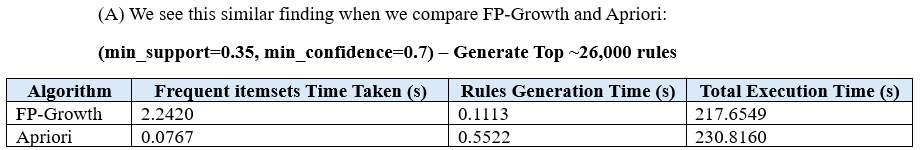


In [10]:
# Model performance comparison
accuracy_apriori, cv_apriori, _ = evaluate_random_forest(X_apriori, y)
accuracy_fp, cv_fp, _ = evaluate_random_forest(X_fp, y)

##### After remove outlier #####
outlier_accuracy_apriori, outlier_cv_apriori, outlier_apriori_rf = evaluate_random_forest(X_apriori, y, outlier_mask)
outlier_accuracy_fp, outlier_cv_fp, outlier_fp_rf = evaluate_random_forest(X_fp, y, outlier_mask)

# Task 2: Using FP-Growth algorithm
print("\n" + "=" * 60)
print("TASK 2: FP-GROWTH ALGORITHM FOR ASSOCIATION RULE MINING")
print("=" * 60)



# Compare Apriori vs FP-Growth
def compare_algorithms(X, y):
    """
    Comprehensive comparison between Apriori and FP-Growth
    """
    print("\nALGORITHM COMPARISON: APRIORI vs FP-GROWTH")
    print("-" * 50)

    print("\nPERFORMANCE METRICS COMPARISON:")
    print(f"{'Metric':<25} {'Apriori':<15} {'FP-Growth':<15}")
    print("-" * 70)
    print(f"{'Creation Time (s)':<25} {apriori_time:<15.4f} {fp_time:<15.4f}")
    print(f"{'Execution Time (s)':<25} {apriori_total_time:<15.4f} {fp_total_time:<15.4f}")
    print(f"{'Rules Generated':<25} {len(rules_apriori):<15} {len(rules_fp):<15}")

    # Memory usage comparison (approximate)
    import sys
    apriori_memory = sys.getsizeof(rules_apriori) if not rules_apriori.empty else 0
    fp_memory = sys.getsizeof(rules_fp) if not rules_fp.empty else 0

    print(f"{'Memory Usage (bytes)':<25} {apriori_memory:<15} {fp_memory:<15}")

    print(f"{'Accuracy':<25} {accuracy_apriori:<15.4f} {accuracy_fp:<15.4f}")
    print(f"{'CV Score':<25} {cv_apriori:<15.4f} {cv_fp:<15.4f}")

    print(f"{'Outlier Accuracy':<25} {outlier_accuracy_apriori:<15.4f} {outlier_accuracy_fp:<15.4f}")
    print(f"{'Outlier CV Score':<25} {outlier_cv_apriori:<15.4f} {outlier_cv_fp:<15.4f}")

    return {
        'apriori': {'time': apriori_total_time, 'accuracy': accuracy_apriori, 'cv_score': cv_apriori},
        'fp_growth': {'time': fp_total_time, 'accuracy': accuracy_fp, 'cv_score': cv_fp}
    }

# Run comparison
comparison_results = compare_algorithms(X, y)



After outlier removal: 445 samples
After outlier removal: 445 samples

TASK 2: FP-GROWTH ALGORITHM FOR ASSOCIATION RULE MINING

ALGORITHM COMPARISON: APRIORI vs FP-GROWTH
--------------------------------------------------

PERFORMANCE METRICS COMPARISON:
Metric                    Apriori         FP-Growth      
----------------------------------------------------------------------
Creation Time (s)         0.3658          1.6058         
Execution Time (s)        83.4603         82.7248        
Rules Generated           26042           26042          
Memory Usage (bytes)      17151972        17151972       
Accuracy                  0.9825          0.9825         
CV Score                  0.9403          0.9385         
Outlier Accuracy          0.9851          0.9851         
Outlier CV Score          0.9730          0.9730         


In [11]:
import pandas as pd
import numpy as np
import time
from itertools import combinations
from collections import defaultdict, Counter
import heapq

## Hybrid-AFP

In [12]:


class Hybrid_AFP_ConditionalB:
    """
    Hybrid algorithm combining Apriori's itemset mining with FP-Growth's rule generation (Conditional Bases).
    """

    def __init__(self, min_support=0.35, min_confidence=0.7):
        self.min_support = min_support
        self.min_confidence = min_confidence
        self.frequent_itemsets = None
        self.rules = None

    def fit(self, transactions):
        """Main method to find frequent itemsets and generate rules."""
        total_start = time.time()

        # Convert transactions to list of sets if needed
        if isinstance(transactions, pd.DataFrame):
            transactions = self._dataframe_to_transactions(transactions)

        # PHASE 1: Apriori-style frequent itemset mining
        itemset_start = time.time()
        self.frequent_itemsets = self._apriori_itemset_mining(transactions)
        itemset_time = time.time() - itemset_start

        # PHASE 2: FP-Growth style rule generation
        rule_start = time.time()
        self.rules = self._fp_growth_rule_generation(transactions, self.frequent_itemsets)
        rule_time = time.time() - rule_start

        total_time = time.time() - total_start

        print(f"True Hybrid - {len(self.frequent_itemsets)} itemsets in {itemset_time:.4f}s")
        print(f"True Hybrid - {len(self.rules)} rules in {rule_time:.4f}s")
        print(f"True Hybrid - Total: {total_time:.4f}s")

        return self.frequent_itemsets, self.rules

    def _dataframe_to_transactions(self, df):
        """Convert DataFrame to list of transaction sets."""
        transactions = []
        for _, row in df.iterrows():
            transaction = set()
            for item, value in row.items():
                if value > 0:  # Binary data
                    transaction.add(item)
            transactions.append(transaction)
        return transactions

    def _apriori_itemset_mining(self, transactions):
        """Apriori algorithm for frequent itemset mining."""
        n_transactions = len(transactions)
        min_support_count = self.min_support * n_transactions

        # Find frequent 1-itemsets
        item_counter = Counter()
        for transaction in transactions:
            for item in transaction:
                item_counter[item] += 1

        frequent_1_itemsets = {frozenset([item]): support
                              for item, support in item_counter.items()
                              if support >= min_support_count}

        frequent_itemsets = frequent_1_itemsets.copy()
        k = 2

        # Find frequent k-itemsets
        while True:
            candidate_itemsets = self._generate_candidates(
                list(frequent_itemsets.keys()), k)

            if not candidate_itemsets:
                break

            # Count support for candidates
            candidate_counts = Counter()
            for transaction in transactions:
                for candidate in candidate_itemsets:
                    if candidate.issubset(transaction):
                        candidate_counts[candidate] += 1

            # Filter by min support
            new_frequent_itemsets = {
                itemset: support
                for itemset, support in candidate_counts.items()
                if support >= min_support_count
            }

            if not new_frequent_itemsets:
                break

            frequent_itemsets.update(new_frequent_itemsets)
            k += 1

        return frequent_itemsets

    def _generate_candidates(self, frequent_itemsets, k):
        """Generate candidate k-itemsets from frequent (k-1)-itemsets."""
        candidates = set()

        for i in range(len(frequent_itemsets)):
            for j in range(i + 1, len(frequent_itemsets)):
                itemset1 = frequent_itemsets[i]
                itemset2 = frequent_itemsets[j]

                # Join step
                if len(itemset1.union(itemset2)) == k:
                    candidate = itemset1.union(itemset2)

                    # Prune step - check if all subsets are frequent
                    if self._has_infrequent_subsets(candidate, frequent_itemsets, k):
                        continue

                    candidates.add(candidate)

        return candidates

    def _has_infrequent_subsets(self, candidate, frequent_itemsets, k):
        """Check if candidate has any infrequent subsets."""
        for subset in combinations(candidate, k - 1):
            if frozenset(subset) not in frequent_itemsets:
                return True
        return False

    def _fp_growth_rule_generation(self, transactions, frequent_itemsets):
        """FP-Growth style efficient rule generation."""
        if not frequent_itemsets:
            return []

        # Build conditional pattern bases for efficient rule generation
        conditional_bases = self._build_conditional_pattern_bases(transactions, frequent_itemsets)

        rules = []
        n_transactions = len(transactions)

        # Generate rules from frequent itemsets
        for itemset, support in frequent_itemsets.items():
            if len(itemset) < 2:
                continue

            # Generate all possible rules from this itemset
            itemset_list = list(itemset)
            for i in range(1, len(itemset_list)):
                for antecedent in combinations(itemset_list, i):
                    antecedent_set = frozenset(antecedent)
                    consequent_set = itemset - antecedent_set

                    # Calculate confidence using conditional pattern bases
                    confidence = self._calculate_confidence(
                        antecedent_set, consequent_set, conditional_bases, n_transactions)

                    if confidence >= self.min_confidence:
                        rules.append({
                            'antecedents': antecedent_set,
                            'consequents': consequent_set,
                            'support': support / n_transactions,
                            'confidence': confidence,
                            'lift': confidence / (frequent_itemsets.get(consequent_set, 0) / n_transactions)
                        })

        return rules

    def _build_conditional_pattern_bases(self, transactions, frequent_itemsets):
        """Build conditional pattern bases for efficient confidence calculation."""
        # Create header table (item -> support)
        header_table = {}
        for itemset, support in frequent_itemsets.items():
            for item in itemset:
                if item not in header_table:
                    header_table[item] = 0
                header_table[item] = max(header_table[item], support)

        # Build FP-tree like structure for efficient lookups
        conditional_bases = {}

        for item in header_table:
            conditional_bases[item] = []
            for transaction in transactions:
                if item in transaction:
                    # Add transaction without the current item
                    conditional_transaction = transaction - {item}
                    if conditional_transaction:
                        conditional_bases[item].append(conditional_transaction)

        return conditional_bases

    def _calculate_confidence(self, antecedent, consequent, conditional_bases, n_transactions):
        """Calculate rule confidence using conditional pattern bases."""
        # For items in consequent, use conditional bases to quickly find support
        if len(consequent) == 1:
            consequent_item = list(consequent)[0]
            if consequent_item in conditional_bases:
                # Count how many transactions containing antecedent also contain consequent
                antecedent_count = 0
                both_count = 0

                for base in conditional_bases[consequent_item]:
                    if antecedent.issubset(base.union({consequent_item})):
                        both_count += 1
                    if antecedent.issubset(base):
                        antecedent_count += 1

                if antecedent_count > 0:
                    return both_count / antecedent_count

        # Fallback: calculate normally
        return self._calculate_confidence_fallback(antecedent, consequent, n_transactions)

    def _calculate_confidence_fallback(self, antecedent, consequent, n_transactions):
        """Fallback method for confidence calculation."""
        # This would scan transactions - in practice you'd use the FP-tree structure
        # For simplicity, we'll use the frequent itemsets (less efficient but works)
        combined = antecedent.union(consequent)
        combined_support = self.frequent_itemsets.get(combined, 0) / n_transactions
        antecedent_support = self.frequent_itemsets.get(antecedent, 0) / n_transactions

        if antecedent_support > 0:
            return combined_support / antecedent_support
        return 0



In [13]:
# Hybrid-AFP using with FP-Growth Tree design
class Hybrid_AFP_FPTree:
    """
    More optimized version that builds actual FP-tree for rule generation.
    """

    class FPTreeNode:
        def __init__(self, item, count, parent):
            self.item = item
            self.count = count
            self.parent = parent
            self.children = {}
            self.next = None  # For header table linkage

    def __init__(self, min_support=0.35, min_confidence=0.7):
        self.min_support = min_support
        self.min_confidence = min_confidence
        self.header_table = {}
        self.frequent_itemsets = {}
    
    def _apriori_itemset_mining(self, transactions):
        """Apriori algorithm for frequent itemset mining."""
        n_transactions = len(transactions)
        min_support_count = self.min_support * n_transactions

        # Find frequent 1-itemsets
        item_counter = Counter()
        for transaction in transactions:
            for item in transaction:
                item_counter[item] += 1

        frequent_1_itemsets = {frozenset([item]): support
                              for item, support in item_counter.items()
                              if support >= min_support_count}

        frequent_itemsets = frequent_1_itemsets.copy()
        k = 2

        # Find frequent k-itemsets
        while True:
            candidate_itemsets = self._generate_candidates(
                list(frequent_itemsets.keys()), k)

            if not candidate_itemsets:
                break

            # Count support for candidates
            candidate_counts = Counter()
            for transaction in transactions:
                for candidate in candidate_itemsets:
                    if candidate.issubset(transaction):
                        candidate_counts[candidate] += 1

            # Filter by min support
            new_frequent_itemsets = {
                itemset: support
                for itemset, support in candidate_counts.items()
                if support >= min_support_count
            }

            if not new_frequent_itemsets:
                break

            frequent_itemsets.update(new_frequent_itemsets)
            k += 1

        return frequent_itemsets
    
    def _generate_candidates(self, frequent_itemsets, k):
        """Generate candidate k-itemsets from frequent (k-1)-itemsets."""
        candidates = set()

        for i in range(len(frequent_itemsets)):
            for j in range(i + 1, len(frequent_itemsets)):
                itemset1 = frequent_itemsets[i]
                itemset2 = frequent_itemsets[j]

                # Join step
                if len(itemset1.union(itemset2)) == k:
                    candidate = itemset1.union(itemset2)

                    # Prune step - check if all subsets are frequent
                    if self._has_infrequent_subsets(candidate, frequent_itemsets, k):
                        continue

                    candidates.add(candidate)

        return candidates

    def _has_infrequent_subsets(self, candidate, frequent_itemsets, k):
        """Check if candidate has any infrequent subsets."""
        for subset in combinations(candidate, k - 1):
            if frozenset(subset) not in frequent_itemsets:
                return True
        return False
    

    def _build_fp_tree(self, transactions):
        """Build FP-tree structure for efficient rule generation."""
        # Build header table
        item_counts = Counter()
        for transaction in transactions:
            for item in transaction:
                item_counts[item] += 1

        n_transactions = len(transactions)
        min_support_count = self.min_support * n_transactions

        # Filter and sort items by frequency
        frequent_items = [item for item, count in item_counts.items()
                         if count >= min_support_count]
        frequent_items.sort(key=lambda x: item_counts[x], reverse=True)

        self.header_table = {}
        for item in frequent_items:
            self.header_table[item] = {'count': item_counts[item], 'link': None}

        # Build tree
        self.root = self.FPTreeNode(None, 0, None)

        for transaction in transactions:
            # Sort transaction by frequency
            sorted_items = [item for item in frequent_items if item in transaction]
            sorted_items.sort(key=lambda x: item_counts[x], reverse=True)

            self._insert_transaction(sorted_items, self.root)

    def _insert_transaction(self, items, node):
        """Insert a transaction into the FP-tree."""
        if not items:
            return

        first_item = items[0]
        if first_item in node.children:
            child = node.children[first_item]
            child.count += 1
        else:
            child = self.FPTreeNode(first_item, 1, node)
            node.children[first_item] = child

            # Link to header table
            if self.header_table[first_item]['link'] is None:
                self.header_table[first_item]['link'] = child
            else:
                current = self.header_table[first_item]['link']
                while current.next is not None:
                    current = current.next
                current.next = child

        # Recursively insert remaining items
        self._insert_transaction(items[1:], child)

    def _generate_rules_fp_style(self, transactions):
        """Generate rules using FP-tree structure for fast confidence calculation."""
        rules = []
        n_transactions = len(transactions)

        for itemset, support in tqdm(self.frequent_itemsets.items()):
            if len(itemset) < 2:
                continue

            itemset_list = list(itemset)
            for i in range(1, len(itemset_list)):
                for antecedent in combinations(itemset_list, i):
                    antecedent_set = frozenset(antecedent)
                    consequent_set = itemset - antecedent_set

                    # Use FP-tree to quickly calculate confidence
                    confidence = self._calculate_confidence_fp_tree(antecedent_set, consequent_set)

                    if confidence >= self.min_confidence:
                        rules.append({
                            'antecedents': antecedent_set,
                            'consequents': consequent_set,
                            'support': support / n_transactions,
                            'confidence': confidence,
                            'lift': confidence / (self.frequent_itemsets.get(consequent_set, 0) / n_transactions)
                        })

        return rules

    def _calculate_confidence_fp_tree(self, antecedent, consequent):
        """Calculate confidence using FP-tree structure."""
        # Traverse FP-tree to find support counts
        # More speed without database scans
        antecedent_count = self._get_support_from_fp_tree(antecedent)
        both_count = self._get_support_from_fp_tree(antecedent.union(consequent))

        if antecedent_count > 0:
            return both_count / antecedent_count
        return 0

    def _get_support_from_fp_tree(self, itemset):
        """Get support count for itemset using FP-tree."""
        if not itemset:
            return 0

        # For single item, use header table
        if len(itemset) == 1:
            item = list(itemset)[0]
            return self.header_table.get(item, {}).get('count', 0)

        # For multiple items, traverse tree (simplified)
        # In full implementation, this would use conditional pattern bases
        return self.frequent_itemsets.get(itemset, 0)


    def _dataframe_to_transactions(self, df):
        """Convert DataFrame to list of transaction sets."""
        transactions = []
        for _, row in df.iterrows():
            transaction = set()
            for item, value in row.items():
                if value > 0:  # Binary data
                    transaction.add(item)
            transactions.append(transaction)
        return transactions
    
    def fit(self, transactions):
        total_start = time.time()

        if isinstance(transactions, pd.DataFrame):
            transactions = self._dataframe_to_transactions(transactions)

        # PHASE 1: Apriori for itemsets
        itemset_start = time.time()
        self.frequent_itemsets = self._apriori_itemset_mining(transactions)
        itemset_time = time.time() - itemset_start

        # PHASE 2: Build FP-tree only for rule generation
        rule_start = time.time()
        self._build_fp_tree(transactions)
        rules = self._generate_rules_fp_style(transactions)
        rule_time = time.time() - rule_start

        total_time = time.time() - total_start

        print(f"FP-Growth Hybrid - {len(self.frequent_itemsets)} itemsets in {itemset_time:.4f}s")
        print(f"FP-Growth Hybrid - {len(rules)} rules in {rule_time:.4f}s")
        print(f"FP-Growth Hybrid - Total: {total_time:.4f}s")

        return self.frequent_itemsets, rules
    
    

In [14]:
def efficient_feature_engineering(df: pd.DataFrame, rules: pd.DataFrame) -> pd.DataFrame:
    """
    Efficient feature engineering using rule-based transformations.
    """
    if len(rules) == 0:
        return df.copy()

    # Select top rules by lift for feature engineering
    top_rules = rules.nlargest(min(20000, len(rules)), 'lift')

    # Create new features based on rule antecedents
    new_features = []
    feature_names = []

    # Time just the feature creation
    start_feature_time = time.time()

    for idx, rule in tqdm(top_rules.iterrows(), total=len(top_rules), desc="Creating features"):
        antecedent = rule['antecedents']
        if len(antecedent) > 0:
            # Create interaction feature - Exclude 'target' from antecedents
            # Filter out 'target' from antecedent items
            filtered_antecedent = [item for item in antecedent if item != 'target']
            
            if len(filtered_antecedent) == 0:
                # Skip if antecedent only contained 'target'
                continue
                
            feature_name = f"rule_{idx}"
            if len(filtered_antecedent) == 1:
                # Single item rule
                item = filtered_antecedent[0]
                new_features.append(df[item].values)
            else:
                # Multiple items - create interaction
                interaction = df[filtered_antecedent].all(axis=1).astype(int)
                new_features.append(interaction.values)
            feature_names.append(feature_name)

    feature_creation_time = time.time() - start_feature_time
    # print(f"Feature creation took: {feature_creation_time:.4f} seconds")

    # Combine original features with new rule-based features
    if new_features:
        new_feature_df = pd.DataFrame(np.column_stack(new_features),
                                    columns=feature_names, index=df.index)
        result_df = pd.concat([df, new_feature_df], axis=1)
    else:
        result_df = df.copy()

    return result_df




In [15]:
# Usage with your existing code
def test_rule_mining1(X, y, min_support=0.35, min_confidence=0.7):
    """Complete feature engineering with true hybrid algorithm."""

    # Binarize data
    X_binarized = (X > X.median()).astype(int)
    X_with_target = X_binarized.copy()
    X_with_target['target'] = y

    # Use true hybrid algorithm
    miner = Hybrid_AFP_ConditionalB(min_support=min_support, min_confidence=min_confidence)
    frequent_itemsets, rules = miner.fit(X_with_target)

    # Convert to DataFrame for compatibility
    rules_df = pd.DataFrame(rules)

    # Feature engineering - use X_binarized (without target) for feature creation
    X_transformed = efficient_feature_engineering(X_binarized, rules_df)

    return X_transformed, rules_df, miner

In [16]:
# Use your existing preprocessing

print("Testing Hybrid-AFP_Conditional Algorithm...")
# Test FP-Growth
start_time = time.time()

X_hybrid, rules_hybrid, miner = test_rule_mining1(X, y)

print(f"Final: {len(rules_hybrid)} rules, {X_hybrid.shape[1]} features")

hybrid_total_time = time.time() - start_time

print(f"{'Execution Time (s)':<25} {hybrid_total_time:<15.4f}")

Testing Hybrid-AFP_Conditional Algorithm...
True Hybrid - 988 itemsets in 11.7608s
True Hybrid - 26042 rules in 1.1367s
True Hybrid - Total: 12.9267s


Creating features: 100%|██████████| 20000/20000 [00:15<00:00, 1255.67it/s]


Final: 26042 rules, 20025 features
Execution Time (s)        29.0476        


In [17]:
# Model performance comparison
accuracy_new, cv_new, _ = evaluate_random_forest(X_hybrid, y)



In [18]:
print(f"{'Accuracy':<25} {accuracy_new:<15.4f}")
print(f"{'CV Score':<25} {cv_new:<15.4f}")


Accuracy                  0.9825         
CV Score                  0.9297         


In [19]:
##### After remove outlier #####
outlier_accuracy_new, outlier_cv_new, outlier_new_rf = evaluate_random_forest(X_apriori, y, outlier_mask)



After outlier removal: 445 samples


In [20]:
print(f"{'Outlier Accuracy':<25} {outlier_accuracy_new:<15.4f}")
print(f"{'Outlier CV Score':<25} {outlier_cv_new:<15.4f}")

Outlier Accuracy          0.9851         
Outlier CV Score          0.9730         


In [21]:
# Usage with your existing code
def test_rule_mining1_v2(X, y, min_support=0.35, min_confidence=0.7):
    """Complete feature engineering with true hybrid algorithm."""

    # Binarize data
    X_binarized = (X > X.median()).astype(int)
    X_with_target = X_binarized.copy()
    X_with_target['target'] = y

    # Use true hybrid algorithm
    miner = Hybrid_AFP_FPTree(min_support=min_support, min_confidence=min_confidence)
    frequent_itemsets, rules = miner.fit(X_with_target)

    # Convert to DataFrame for compatibility
    rules_df = pd.DataFrame(rules)

    # Feature engineering (using your existing function)
    X_transformed = efficient_feature_engineering(X_binarized, rules_df)

    return X_transformed, rules_df, miner

In [22]:
# Use your existing preprocessing -- Ablation Study (Hybrid-AFP with FP-Growth Tree)

print("Testing Hybrid-AFP_FPTree...")

start_time = time.time()

X_hybrid, rules_hybrid, miner = test_rule_mining1_v2(X, y)

print(f"Final: {len(rules_hybrid)} rules, {X_hybrid.shape[1]} features")

hybrid_total_time = time.time() - start_time

print(f"{'Execution Time (s)':<25} {hybrid_total_time:<15.4f}")

Testing Hybrid-AFP_FPTree...


100%|██████████| 988/988 [00:00<00:00, 17187.13it/s]


FP-Growth Hybrid - 988 itemsets in 12.0820s
FP-Growth Hybrid - 26042 rules in 0.0812s
FP-Growth Hybrid - Total: 12.1828s


Creating features: 100%|██████████| 20000/20000 [00:15<00:00, 1291.60it/s]


Final: 26042 rules, 20028 features
Execution Time (s)        27.9014        


In [23]:
# Model performance comparison
accuracy_new, cv_new, _ = evaluate_random_forest(X_hybrid, y)



In [24]:
print(f"{'Accuracy':<25} {accuracy_new:<15.4f}")
print(f"{'CV Score':<25} {cv_new:<15.4f}")


Accuracy                  0.9825         
CV Score                  0.9314         


In [25]:
##### After remove outlier #####
outlier_accuracy_new, outlier_cv_new, outlier_new_rf = evaluate_random_forest(X_apriori, y, outlier_mask)



After outlier removal: 445 samples


In [26]:
print(f"{'Outlier Accuracy':<25} {outlier_accuracy_new:<15.4f}")
print(f"{'Outlier CV Score':<25} {outlier_cv_new:<15.4f}")

Outlier Accuracy          0.9851         
Outlier CV Score          0.9730         
